<a href="https://colab.research.google.com/github/hairuo55/TTS-frontend/blob/master/optimize_cutoff_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.optimize as optimize
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import torch.nn.functional as F
import scipy
from scipy.signal import kaiser

def design_prototype_filter(taps=62, cutoff_ratio=0.15, beta=9.0):
    """Design prototype filter for PQMF.
    This method is based on `A Kaiser window approach for the design of prototype
    filters of cosine modulated filterbanks`_.
    Args:
        taps (int): The number of filter taps.
        cutoff_ratio (float): Cut-off frequency ratio.
        beta (float): Beta coefficient for kaiser window.
    Returns:
        ndarray: Impluse response of prototype filter (taps + 1,).
    .. _`A Kaiser window approach for the design of prototype filters of cosine modulated filterbanks`:
        https://ieeexplore.ieee.org/abstract/document/681427
    """
    # check the arguments are valid
    assert taps % 2 == 0, "The number of taps mush be even number."
    assert 0.0 < cutoff_ratio < 1.0, "Cutoff ratio must be > 0.0 and < 1.0."

    # make initial filter
    omega_c = np.pi * cutoff_ratio
    with np.errstate(invalid='ignore'):
        h_i = np.sin(omega_c * (np.arange(taps + 1) - 0.5 * taps)) \
            / (np.pi * (np.arange(taps + 1) - 0.5 * taps))
        
    h_i[taps // 2] = np.cos(0) * cutoff_ratio  # fix nan due to indeterminate form

    # apply kaiser window
    w = kaiser(taps + 1, beta)
    h = h_i * w

    return h

class PQMF(torch.nn.Module):
    """PQMF module.
    This module is based on `Near-perfect-reconstruction pseudo-QMF banks`_.
    .. _`Near-perfect-reconstruction pseudo-QMF banks`:
        https://ieeexplore.ieee.org/document/258122
    """

    def __init__(self, subbands=4, taps=62, cutoff_ratio=0.15, beta=9.0):
        """Initilize PQMF module.
        Args:
            subbands (int): The number of subbands.
            taps (int): The number of filter taps.
            cutoff_ratio (float): Cut-off frequency ratio.
            beta (float): Beta coefficient for kaiser window.
        """
        super(PQMF, self).__init__()

        # define filter coefficient
        h_proto = design_prototype_filter(taps, cutoff_ratio, beta)
        self.h_proto = h_proto
        h_analysis = np.zeros((subbands, len(h_proto)))
        h_synthesis = np.zeros((subbands, len(h_proto)))
        for k in range(subbands):
            h_analysis[k] = 2 * h_proto * np.cos(
                (2 * k + 1) * (np.pi / (2 * subbands)) *
                (np.arange(taps + 1) - (taps / 2)) +
                (-1) ** k * np.pi / 4)                               # <--- fix (taps - 1) -> taps
            h_synthesis[k] = 2 * h_proto * np.cos(
                (2 * k + 1) * (np.pi / (2 * subbands)) *
                (np.arange(taps + 1) - (taps / 2)) -
                (-1) ** k * np.pi / 4)

        # convert to tensor
        analysis_filter = torch.from_numpy(h_analysis).float().unsqueeze(1)
        synthesis_filter = torch.from_numpy(h_synthesis).float().unsqueeze(0)

        # register coefficients as beffer
        self.register_buffer("analysis_filter", analysis_filter)
        self.register_buffer("synthesis_filter", synthesis_filter)

        # filter for downsampling & upsampling
        updown_filter = torch.zeros((subbands, subbands, subbands)).float()
        for k in range(subbands):
            updown_filter[k, k, 0] = 1.0
        self.register_buffer("updown_filter", updown_filter)
        self.subbands = subbands

        # keep padding info
        self.pad_fn = torch.nn.ConstantPad1d(taps // 2, 0.0)

    def analysis(self, x):
        """Analysis with PQMF.
        Args:
            x (Tensor): Input tensor (B, 1, T).
        Returns:
            Tensor: Output tensor (B, subbands, T // subbands).
        """
        x = F.conv1d(self.pad_fn(x), self.analysis_filter)
        return F.conv1d(x, self.updown_filter, stride=self.subbands)

    def synthesis(self, x):
        """Synthesis with PQMF.
        Args:
            x (Tensor): Input tensor (B, subbands, T // subbands).
        Returns:
            Tensor: Output tensor (B, 1, T).
        """
        # NOTE(kan-bayashi): Power will be dreased so here multipy by # subbands.
        #   Not sure this is the correct way, it is better to check again.
        # TODO(kan-bayashi): Understand the reconstruction procedure
        x = F.conv_transpose1d(x, self.updown_filter * self.subbands, stride=self.subbands)
        return F.conv1d(self.pad_fn(x), self.synthesis_filter)
    

optimized cutoff ratio value = 0.14198


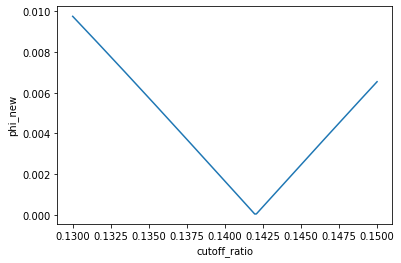

In [ ]:
#### Optimize cutoff_ratio
M = 4
taps = 62

def _objective(w):
    pqmf = PQMF(M, cutoff_ratio=w, taps=taps)
    h_proto = pqmf.h_proto
    conv_h_proto = np.convolve(h_proto, h_proto[::-1], mode='full')
    length_conv_h = conv_h_proto.shape[0]
    half_length = length_conv_h // 2

    check_steps = np.arange((half_length)// (2*M))*2*M
    _phi_new = conv_h_proto[half_length:][check_steps]
    phi_new = np.abs(_phi_new[1:]).max()
    diff_zero_coef = np.abs(_phi_new[0] - 1/(2*M)) # Since phi_new is not convex, I think this value should also be considered. 
    return phi_new #+ diff_zero_coef

objs = []
lins = np.linspace(0.13, 0.15, 1001)
for w in lins:
    phi_new = _objective(w)
    objs.append(phi_new)

plt.plot(lins, objs)
plt.xlabel('cutoff_ratio')
plt.ylabel('phi_new')
opt_cutoff_ratio = lins[np.argmin(objs)]
print('optimized cutoff ratio value =', opt_cutoff_ratio)

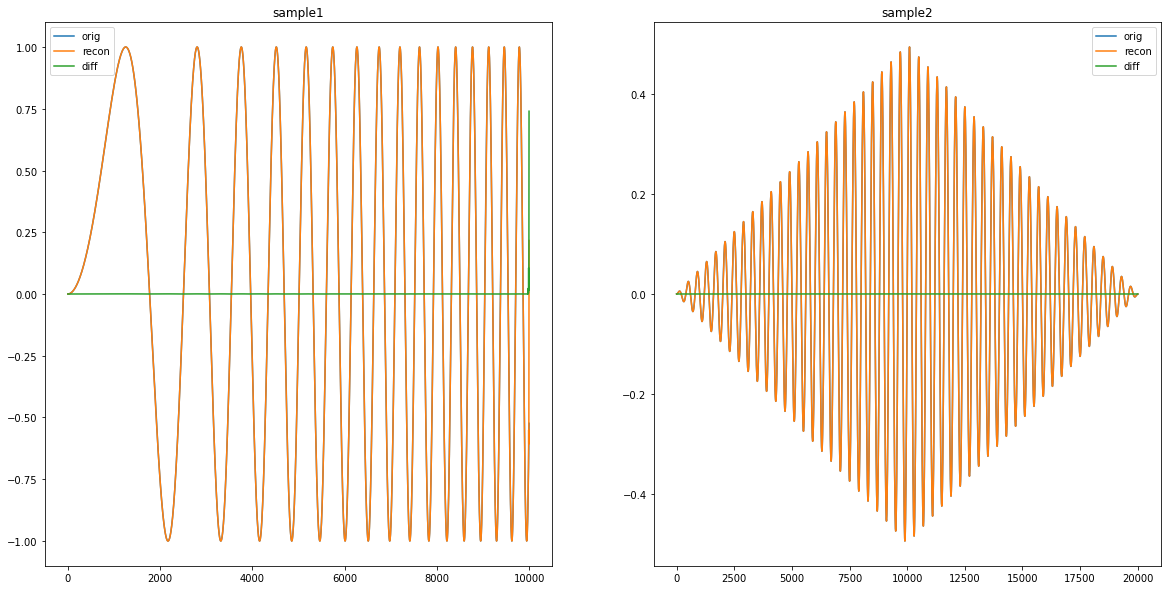

In [ ]:
pqmf = PQMF(M, 
            cutoff_ratio=opt_cutoff_ratio, 
            taps=taps)
h_proto = pqmf.h_proto

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# sample sine wave 
ax = axes[0]
sinw = np.sin(np.arange(10000)**2 / 1000000) 
with torch.no_grad():
    sinw_tensor = torch.from_numpy(sinw).float().reshape(1, 1, -1)
    rec = pqmf.synthesis(pqmf.analysis(sinw_tensor)).squeeze().numpy()
ax.set_title('sample1')
ax.plot(sinw, label='orig')
ax.plot(rec, label='recon')
ax.plot(np.abs(sinw - rec), label='diff')
ax.legend()

ax = axes[1]
sinw = np.sin(np.arange(20000) / 20000 * (100 * np.pi)) * (0.5 - np.abs(np.arange(20000)/20000 - 0.5))
with torch.no_grad():
    sinw_tensor = torch.from_numpy(sinw).float().reshape(1, 1, -1)
    rec = pqmf.synthesis(pqmf.analysis(sinw_tensor)).squeeze().numpy()
ax.set_title('sample2')
ax.plot(sinw, label='orig')
ax.plot(rec, label='recon')
ax.plot(np.abs(sinw - rec), label='diff')
ax.legend()
plt.show()
plt.close()

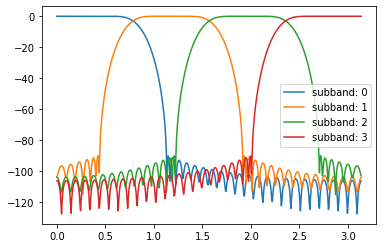

In [ ]:
from scipy import signal 
analysis_filter = pqmf.analysis_filter.numpy()
n_filter = len(analysis_filter)
for fid in range(n_filter):
    filter = analysis_filter[fid, 0]
    w, h = signal.freqz(filter)
    plt.plot(w, 20 * np.log10(abs(h)), label='subband: %d' % fid)
plt.legend()
plt.show()
plt.close()

In [ ]:
### other cases

M = 8
taps = 62
ret = optimize.minimize(_objective, 
                        np.array([0.075]), 
                        bounds=optimize.Bounds(0.05, 0.10))
opt_cutoff_ratio = ret.x[0]
print('optimized cutoff ratio value =', opt_cutoff_ratio)

optimized cutoff ratio value = 0.07943385232004205


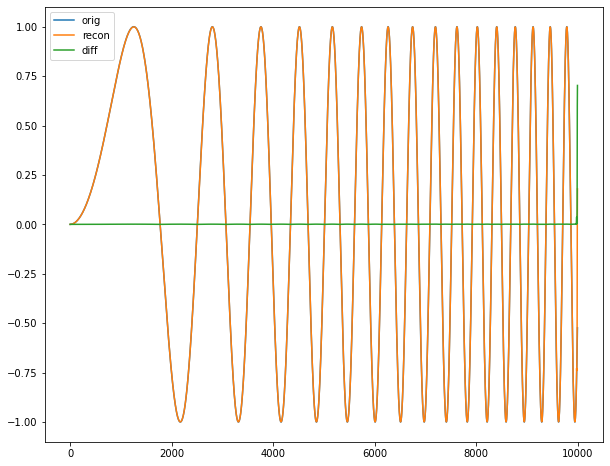

In [ ]:
pqmf = PQMF(M, cutoff_ratio=opt_cutoff_ratio, taps=taps)
h_proto = pqmf.h_proto

fig, ax = plt.subplots(figsize=(10, 8))
sinw = np.sin(np.arange(10000)**2 / 1000000) 
with torch.no_grad():
    sinw_tensor = torch.from_numpy(sinw).float().reshape(1, 1, -1)
    rec = pqmf.synthesis(pqmf.analysis(sinw_tensor)).squeeze().numpy()

ax.plot(sinw, label='orig')
ax.plot(rec, label='recon')
ax.plot(np.abs(sinw - rec), label='diff')
plt.legend()
plt.show()
plt.close()